In [1]:
!unzip /content/drive/MyDrive/archive.zip -d /content/chest_xray


Streaming output truncated to the last 5000 lines.
  inflating: /content/chest_xray/chest_xray/train/NORMAL/NORMAL-2558319-0001.jpeg  
  inflating: /content/chest_xray/chest_xray/train/NORMAL/NORMAL-2558319-0002.jpeg  
  inflating: /content/chest_xray/chest_xray/train/NORMAL/NORMAL-2559035-0001.jpeg  
  inflating: /content/chest_xray/chest_xray/train/NORMAL/NORMAL-2559035-0002.jpeg  
  inflating: /content/chest_xray/chest_xray/train/NORMAL/NORMAL-2565226-0001.jpeg  
  inflating: /content/chest_xray/chest_xray/train/NORMAL/NORMAL-2568157-0001.jpeg  
  inflating: /content/chest_xray/chest_xray/train/NORMAL/NORMAL-2597757-0001.jpeg  
  inflating: /content/chest_xray/chest_xray/train/NORMAL/NORMAL-2597757-0002.jpeg  
  inflating: /content/chest_xray/chest_xray/train/NORMAL/NORMAL-263932-0001.jpeg  
  inflating: /content/chest_xray/chest_xray/train/NORMAL/NORMAL-2646645-0001.jpeg  
  inflating: /content/chest_xray/chest_xray/train/NORMAL/NORMAL-2646923-0001.jpeg  
  inflating: /content/ches

In [2]:
import os
import numpy as np
import cv2
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
%matplotlib inline
from PIL import Image
from IPython.display import display
import torch
import torch.nn as nn
from torch.utils.data import DataLoader
import torch.nn.functional as F
from torchvision import datasets, transforms, models
from torch.optim.lr_scheduler import StepLR
from torchsummary import summary
from tqdm import tqdm


In [3]:
data_path = '/content/chest_xray/chest_xray'
print(os.listdir(data_path))  # to check what is inside


['train', 'test']


In [4]:
# Path to one NORMAL image
normal_folder = os.path.join(data_path, "train", "NORMAL")
pneumonia_folder = os.path.join(data_path, "train", "PNEUMONIA")

# List images in NORMAL folder
normal_images = os.listdir(normal_folder)
pneumonia_images = os.listdir(pneumonia_folder)

print("Number of NORMAL images:", len(normal_images))
print("Number of PNEUMONIA images:", len(pneumonia_images))

Number of NORMAL images: 1349
Number of PNEUMONIA images: 3883


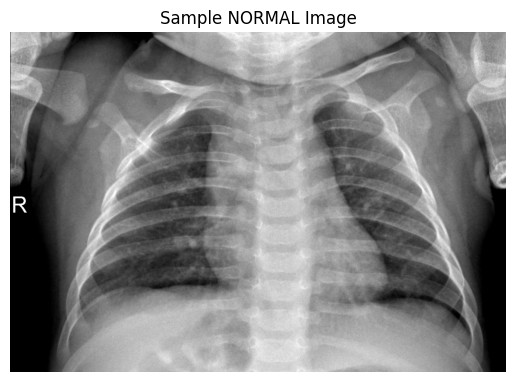

In [5]:
# Show one NORMAL image
img_normal = mpimg.imread(os.path.join(normal_folder, normal_images[0]))
plt.imshow(img_normal, cmap='gray')
plt.title("Sample NORMAL Image")
plt.axis('off')
plt.show()


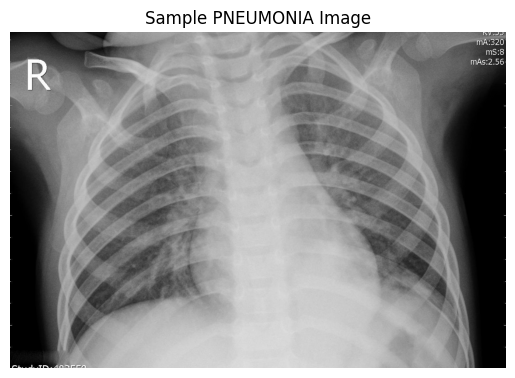

In [6]:
# Show one PNEUMONIA image
img_pneumonia = mpimg.imread(os.path.join(pneumonia_folder, pneumonia_images[0]))
plt.imshow(img_pneumonia, cmap='gray')
plt.title("Sample PNEUMONIA Image")
plt.axis('off')
plt.show()

In [7]:
# Step 1: Define class names
class_name = ['NORMAL', 'PNEUMONIA']

# Step 2: Function to list files inside a folder
def get_list_files(dirName):
    '''
    input - directory location
    output - list the files in the directory
    '''
    files_list = os.listdir(dirName)
    return files_list

# Step 3: Get file lists for train and test
files_list_normal_train = get_list_files(data_path + '/train/' + class_name[0])
files_list_pneu_train = get_list_files(data_path + '/train/' + class_name[1])
files_list_normal_test = get_list_files(data_path + '/test/' + class_name[0])
files_list_pneu_test = get_list_files(data_path + '/test/' + class_name[1])

# Step 4: Print counts
print("Number of train samples in Normal category {}".format(len(files_list_normal_train)))
print("Number of train samples in Pneumonia category {}".format(len(files_list_pneu_train)))
print("Number of test samples in Normal category {}".format(len(files_list_normal_test)))
print("Number of test samples in Pneumonia category {}".format(len(files_list_pneu_test)))


Number of train samples in Normal category 1349
Number of train samples in Pneumonia category 3883
Number of test samples in Normal category 234
Number of test samples in Pneumonia category 390


(1781, 2080)


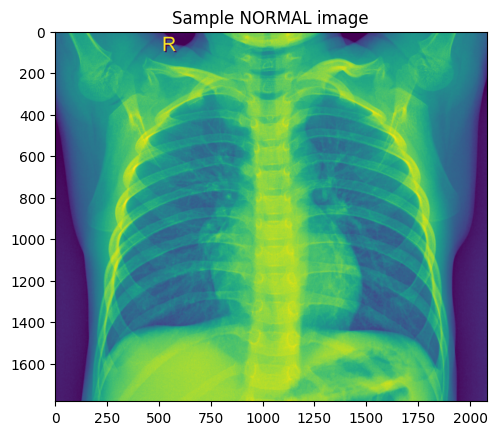

In [8]:
# Show a random NORMAL image
rand_img_no = np.random.randint(0, len(files_list_normal_train))
img = data_path + '/train/NORMAL/' + files_list_normal_train[rand_img_no]
print(plt.imread(img).shape)
img = mpimg.imread(img)
plt.imshow(img)
plt.title("Sample NORMAL image")
plt.show()

(600, 1040)


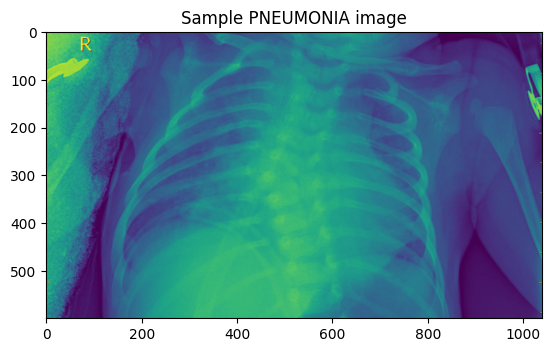

In [9]:
# Show a random PNEUMONIA image
img = data_path + '/train/PNEUMONIA/' + files_list_pneu_train[np.random.randint(0, len(files_list_pneu_train))]
print(plt.imread(img).shape)
img = mpimg.imread(img)
plt.imshow(img)
plt.title("Sample PNEUMONIA image")
plt.show()

In [10]:
# Step 1: Define transformations for train and test data
train_transform = transforms.Compose([
    transforms.Resize(224),
    transforms.CenterCrop(224),
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406],
                         [0.229, 0.224, 0.225])
])

test_transform = transforms.Compose([
    transforms.Resize(224),
    transforms.CenterCrop(224),
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406],
                         [0.229, 0.224, 0.225])
])

# Step 2: Load data from folders
train_data = datasets.ImageFolder(os.path.join(data_path, 'train'), transform=train_transform)
test_data = datasets.ImageFolder(os.path.join(data_path, 'test'), transform=test_transform)

# Step 3: Create data loaders
train_loader = DataLoader(train_data, batch_size=16, shuffle=True, pin_memory=True)
test_loader = DataLoader(test_data, batch_size=1, shuffle=False, pin_memory=True)

# Step 4: Print some info
class_names = train_data.classes
print(class_names)
print(f'Number of train images: {len(train_data)}')
print(f'Number of test images: {len(test_data)}')


['NORMAL', 'PNEUMONIA']
Number of train images: 5232
Number of test images: 624


In [ ]:
class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()

        # Input Block
        self.convblock1 = nn.Sequential(
            nn.Conv2d(in_channels=3, out_channels=8, kernel_size=(3, 3), padding=0, bias=False),
            nn.ReLU(),
            # nn.BatchNorm2d(8)  # Uncomment if you want batch normalization
        )
        self.pool11 = nn.MaxPool2d(2, 2)

        # Convolution Block 2
        self.convblock2 = nn.Sequential(
            nn.Conv2d(in_channels=8, out_channels=16, kernel_size=(3, 3), padding=0, bias=False),
            nn.ReLU(),
            # nn.BatchNorm2d(16)
        )

        # Transition Block
        self.pool22 = nn.MaxPool2d(2, 2)
        self.convblock3 = nn.Sequential(
            nn.Conv2d(in_channels=16, out_channels=10, kernel_size=(1, 1), padding=0, bias=False),
            nn.ReLU()
        )
        self.pool33 = nn.MaxPool2d(2, 2)

        # Convolution Blocks 4–11
        self.convblock4 = nn.Sequential(
            nn.Conv2d(in_channels=10, out_channels=10, kernel_size=(3, 3), padding=0, bias=False),
            nn.ReLU()
        )
        self.convblock5 = nn.Sequential(
            nn.Conv2d(in_channels=10, out_channels=32, kernel_size=(1, 1), padding=0, bias=False),
            nn.ReLU()
        )
        self.convblock6 = nn.Sequential(
            nn.Conv2d(in_channels=32, out_channels=10, kernel_size=(1, 1), padding=0, bias=False),
            nn.ReLU()
        )
        self.convblock7 = nn.Sequential(
            nn.Conv2d(in_channels=10, out_channels=10, kernel_size=(3, 3), padding=0, bias=False),
            nn.ReLU()
        )
        self.convblock8 = nn.Sequential(
            nn.Conv2d(in_channels=10, out_channels=32, kernel_size=(1, 1), padding=0, bias=False),
            nn.ReLU()
        )
        self.convblock9 = nn.Sequential(
            nn.Conv2d(in_channels=32, out_channels=10, kernel_size=(1, 1), padding=0, bias=False),
            nn.ReLU()
        )
        self.convblock10 = nn.Sequential(
            nn.Conv2d(in_channels=10, out_channels=14, kernel_size=(3, 3), padding=0, bias=False),
            nn.ReLU()
        )
        self.convblock11 = nn.Sequential(
            nn.Conv2d(in_channels=14, out_channels=16, kernel_size=(3, 3), padding=0, bias=False),
            nn.ReLU()
        )

        # Output Block
        self.gap = nn.AvgPool2d(kernel_size=4)
        self.convblockout = nn.Conv2d(in_channels=16, out_channels=2, kernel_size=(4, 4), padding=0, bias=False)

    def forward(self, x):
        x = self.convblock1(x)
        x = self.pool11(x)
        x = self.convblock2(x)
        x = self.pool22(x)
        x = self.convblock3(x)
        x = self.pool33(x)
        x = self.convblock4(x)
        x = self.convblock5(x)
        x = self.convblock6(x)
        x = self.convblock7(x)
        x = self.convblock8(x)
        x = self.convblock9(x)
        x = self.convblock10(x)
        x = self.convblock11(x)
        x = self.gap(x)
        x = self.convblockout(x)
        x = x.view(-1, 2)  # Flatten
        return F.log_softmax(x, dim=-1)


In [ ]:
# Check CUDA availability
use_cuda = torch.cuda.is_available()
device = torch.device("cuda" if use_cuda else "cpu")
print(f"Available processor: {device}")

# Instantiate the model and move to device
model = Net().to(device)

# Print model summary
summary(model, input_size=(3, 224, 224))


Available processor: cuda
----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1          [-1, 8, 222, 222]             216
              ReLU-2          [-1, 8, 222, 222]               0
         MaxPool2d-3          [-1, 8, 111, 111]               0
            Conv2d-4         [-1, 16, 109, 109]           1,152
              ReLU-5         [-1, 16, 109, 109]               0
         MaxPool2d-6           [-1, 16, 54, 54]               0
            Conv2d-7           [-1, 10, 54, 54]             160
              ReLU-8           [-1, 10, 54, 54]               0
         MaxPool2d-9           [-1, 10, 27, 27]               0
           Conv2d-10           [-1, 10, 25, 25]             900
             ReLU-11           [-1, 10, 25, 25]               0
           Conv2d-12           [-1, 32, 25, 25]             320
             ReLU-13           [-1, 32, 25, 25]               0
           Co

In [ ]:
# Lists to store metrics
train_losses = []
test_losses = []
train_acc = []
test_acc = []

# Training function
def train(model, device, train_loader, optimizer, epoch):
    model.train()  # set model to training mode
    pbar = tqdm(train_loader)  # progress bar
    correct = 0
    processed = 0

    for batch_idx, (data, target) in enumerate(pbar):
        # Move data to device
        data, target = data.to(device), target.to(device)

        # 1. Initialize gradients
        optimizer.zero_grad()

        # 2. Forward pass
        y_pred = model(data)

        # 3. Calculate loss
        loss = F.nll_loss(y_pred, target)
        train_losses.append(loss.item())

        # 4. Backpropagation
        loss.backward()

        # 5. Optimizer step
        optimizer.step()

        # Calculate training accuracy
        pred = y_pred.argmax(dim=1, keepdim=True)
        correct += pred.eq(target.view_as(pred)).sum().item()
        processed += len(data)

        pbar.set_description(
            desc=f'Epoch={epoch} Loss={loss.item():.4f} Batch={batch_idx} Accuracy={100*correct/processed:.2f}%'
        )
        train_acc.append(100 * correct / processed)

# Testing function
def test(model, device, test_loader):
    model.eval()  # set model to evaluation mode
    test_loss = 0
    correct = 0

    with torch.no_grad():
        for data, target in test_loader:
            data, target = data.to(device), target.to(device)

            # Forward pass
            output = model(data)

            # Calculate loss (sum over batch for average later)
            test_loss += F.nll_loss(output, target, reduction='sum').item()

            # Calculate accuracy
            pred = output.argmax(dim=1, keepdim=True)
            correct += pred.eq(target.view_as(pred)).sum().item()

    test_loss /= len(test_loader.dataset)
    test_losses.append(test_loss)

    print(
        f'\nTest set: Average loss: {test_loss:.4f}, Accuracy: {correct}/{len(test_loader.dataset)} '
        f'({100. * correct / len(test_loader.dataset):.2f}%)\n'
    )
    test_acc.append(100. * correct / len(test_loader.dataset))


EPOCH: 0


Epoch=0 Loss=0.6931 Batch=326 Accuracy=30.03%: 100%|██████████| 327/327 [01:34<00:00,  3.45it/s]


current Learning Rate:  0.01

Test set: Average loss: 0.6931, Accuracy: 266/624 (42.63%)

EPOCH: 1


Epoch=1 Loss=0.6931 Batch=326 Accuracy=35.82%: 100%|██████████| 327/327 [01:31<00:00,  3.58it/s]


current Learning Rate:  0.01

Test set: Average loss: 0.6931, Accuracy: 299/624 (47.92%)

EPOCH: 2


Epoch=2 Loss=0.6931 Batch=326 Accuracy=44.11%: 100%|██████████| 327/327 [01:31<00:00,  3.57it/s]


current Learning Rate:  0.01

Test set: Average loss: 0.6931, Accuracy: 347/624 (55.61%)

EPOCH: 3


Epoch=3 Loss=0.6931 Batch=326 Accuracy=54.57%: 100%|██████████| 327/327 [01:32<00:00,  3.55it/s]


current Learning Rate:  0.01

Test set: Average loss: 0.6931, Accuracy: 391/624 (62.66%)

EPOCH: 4


Epoch=4 Loss=0.6931 Batch=326 Accuracy=64.33%: 100%|██████████| 327/327 [01:31<00:00,  3.55it/s]


current Learning Rate:  0.01

Test set: Average loss: 0.6931, Accuracy: 424/624 (67.95%)

EPOCH: 5


Epoch=5 Loss=0.6931 Batch=326 Accuracy=70.55%: 100%|██████████| 327/327 [01:31<00:00,  3.56it/s]


current Learning Rate:  0.005

Test set: Average loss: 0.6931, Accuracy: 443/624 (70.99%)

EPOCH: 6


Epoch=6 Loss=0.6931 Batch=326 Accuracy=73.24%: 100%|██████████| 327/327 [01:31<00:00,  3.58it/s]


current Learning Rate:  0.005

Test set: Average loss: 0.6931, Accuracy: 447/624 (71.63%)

EPOCH: 7


Epoch=7 Loss=0.6931 Batch=326 Accuracy=74.50%: 100%|██████████| 327/327 [01:31<00:00,  3.58it/s]


current Learning Rate:  0.005

Test set: Average loss: 0.6931, Accuracy: 447/624 (71.63%)

EPOCH: 8


Epoch=8 Loss=0.6931 Batch=326 Accuracy=75.23%: 100%|██████████| 327/327 [01:32<00:00,  3.55it/s]


current Learning Rate:  0.005

Test set: Average loss: 0.6931, Accuracy: 449/624 (71.96%)

EPOCH: 9


Epoch=9 Loss=0.6931 Batch=326 Accuracy=75.57%: 100%|██████████| 327/327 [01:32<00:00,  3.54it/s]


current Learning Rate:  0.005

Test set: Average loss: 0.6931, Accuracy: 440/624 (70.51%)

EPOCH: 10


Epoch=10 Loss=0.6931 Batch=326 Accuracy=76.43%: 100%|██████████| 327/327 [01:32<00:00,  3.54it/s]


current Learning Rate:  0.005

Test set: Average loss: 0.6931, Accuracy: 434/624 (69.55%)

EPOCH: 11


Epoch=11 Loss=0.6931 Batch=326 Accuracy=76.91%: 100%|██████████| 327/327 [01:32<00:00,  3.55it/s]


current Learning Rate:  0.0025

Test set: Average loss: 0.6931, Accuracy: 433/624 (69.39%)

EPOCH: 12


Epoch=12 Loss=0.6931 Batch=326 Accuracy=77.01%: 100%|██████████| 327/327 [01:32<00:00,  3.55it/s]


current Learning Rate:  0.0025

Test set: Average loss: 0.6931, Accuracy: 432/624 (69.23%)

EPOCH: 13


Epoch=13 Loss=0.6931 Batch=326 Accuracy=77.16%: 100%|██████████| 327/327 [01:32<00:00,  3.54it/s]


current Learning Rate:  0.0025

Test set: Average loss: 0.6931, Accuracy: 431/624 (69.07%)

EPOCH: 14


Epoch=14 Loss=0.6931 Batch=326 Accuracy=77.12%: 100%|██████████| 327/327 [01:32<00:00,  3.53it/s]


current Learning Rate:  0.0025

Test set: Average loss: 0.6931, Accuracy: 427/624 (68.43%)



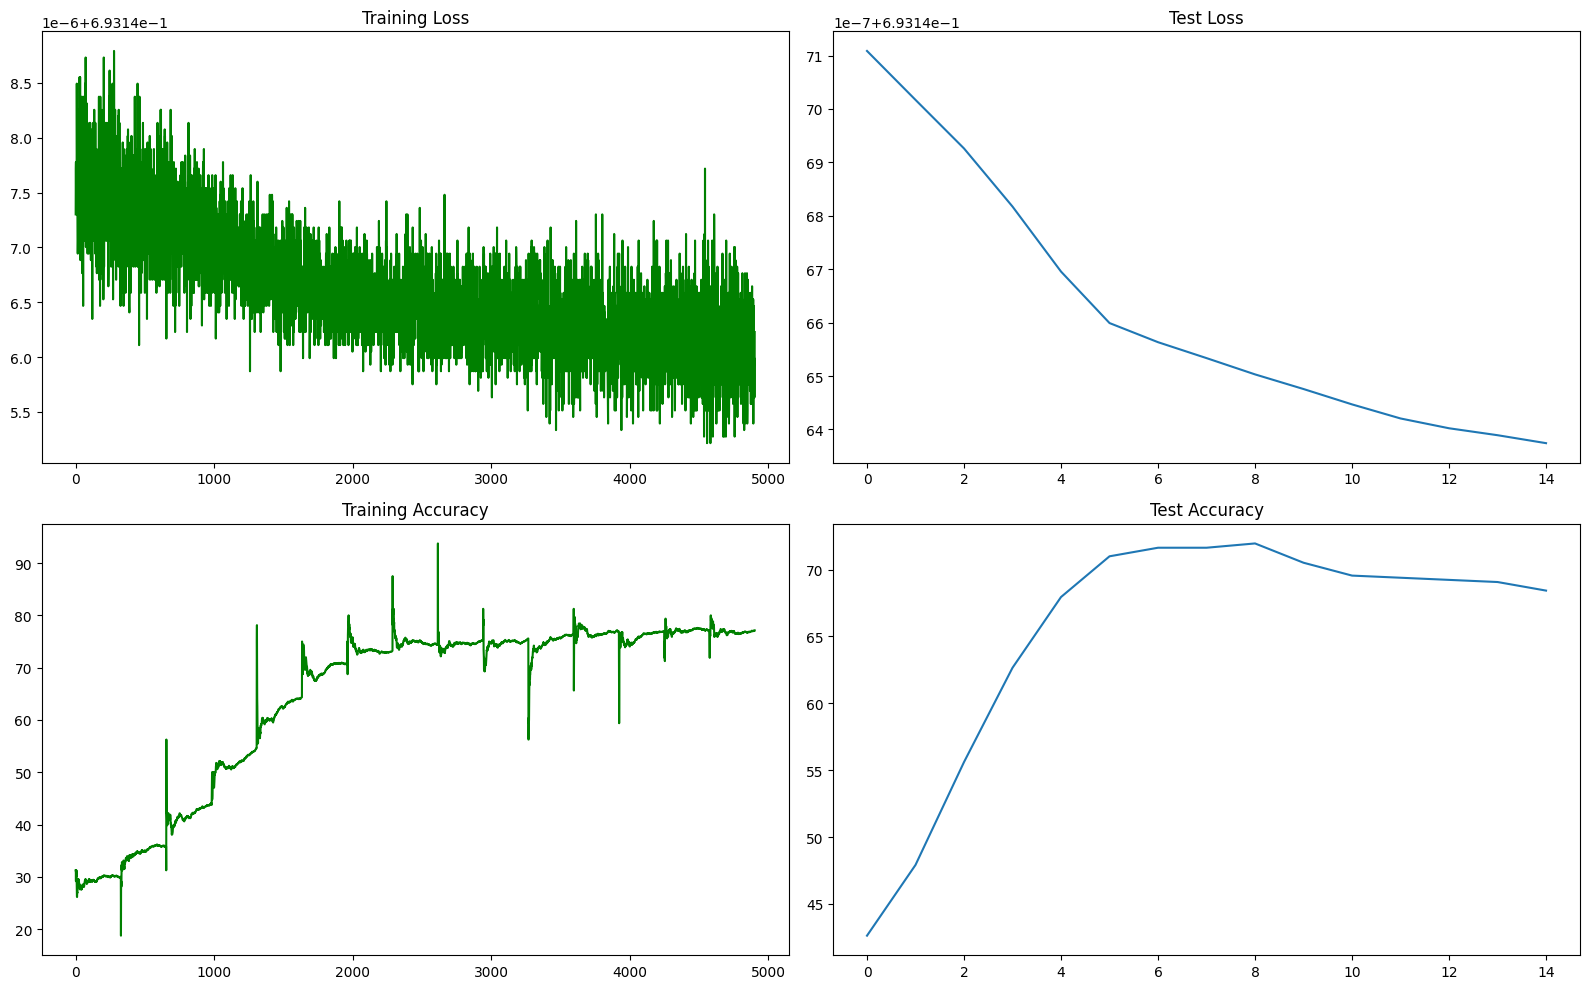

In [ ]:
# --- Optimizer, scheduler, and epoch loop (as in book) ---
# Ensure model and device exist; create/restore if needed:
# use_cuda = torch.cuda.is_available()
# device = torch.device("cuda" if use_cuda else "cpu")

model = Net().to(device)                  # instantiate model (book)
optimizer = torch.optim.SGD(model.parameters(), lr=0.01, momentum=0.9)
scheduler = StepLR(optimizer, step_size=6, gamma=0.5)
EPOCHS = 15

for epoch in range(EPOCHS):
    print("EPOCH:", epoch)
    train(model, device, train_loader, optimizer, epoch)
    scheduler.step()
    print('current Learning Rate: ', optimizer.state_dict()["param_groups"][0]["lr"])
    test(model, device, test_loader)


# --- Plotting losses & accuracies (book visualization, made robust) ---
# Convert train_losses items to floats (handles tensors or floats)
train_losses1 = []
for i in train_losses:
    if isinstance(i, (float, int)):
        train_losses1.append(float(i))
    else:
        # e.g., tensor
        train_losses1.append(float(i.cpu().detach().numpy()))

train_acc1 = [i for i in train_acc]
test_losses1 = [i for i in test_losses]
test_acc1 = [i for i in test_acc]

fig, axs = plt.subplots(2, 2, figsize=(16, 10))

axs[0, 0].plot(train_losses1, color='green')
axs[0, 0].set_title("Training Loss")

axs[1, 0].plot(train_acc1, color='green')
axs[1, 0].set_title("Training Accuracy")

axs[0, 1].plot(test_losses1)
axs[0, 1].set_title("Test Loss")

axs[1, 1].plot(test_acc1)
axs[1, 1].set_title("Test Accuracy")

plt.tight_layout()
plt.show()

In [ ]:
from torchvision import transforms

# --- New Augmented Train Transform ---
train_transform = transforms.Compose([
    transforms.Resize(224),
    transforms.CenterCrop(224),

    # 📌 AUGMENTATIONS
    transforms.ColorJitter(brightness=0.10, contrast=0.10,
                           saturation=0.10, hue=0.10),
    transforms.RandomHorizontalFlip(),
    transforms.RandomRotation(10),

    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406],
                         [0.229, 0.224, 0.225])
])

# --- Test Transform (no augmentation, just normalization) ---
test_transform = transforms.Compose([
    transforms.Resize(224),
    transforms.CenterCrop(224),
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406],
                         [0.229, 0.224, 0.225])
])


In [ ]:
from torchvision import datasets
from torch.utils.data import DataLoader

train_data = datasets.ImageFolder(root="/content/chest_xray/chest_xray/train",
                                  transform=train_transform)
test_data = datasets.ImageFolder(root="/content/chest_xray/chest_xray/test",
                                 transform=test_transform)

train_loader = DataLoader(train_data, batch_size=32, shuffle=True)
test_loader = DataLoader(test_data, batch_size=32, shuffle=False)

print(f"Train samples: {len(train_data)}, Test samples: {len(test_data)}")


Train samples: 5232, Test samples: 624


In [ ]:
model = Net().to(device)
optimizer = torch.optim.SGD(model.parameters(), lr=0.01, momentum=0.9)
scheduler = StepLR(optimizer, step_size=6, gamma=0.5)
EPOCHS = 15

for epoch in range(EPOCHS):
    print("EPOCH:", epoch)
    train(model, device, train_loader, optimizer, epoch)
    scheduler.step()
    print('current Learning Rate: ', optimizer.state_dict()["param_groups"][0]["lr"])
    test(model, device, test_loader)


EPOCH: 0


Epoch=0 Loss=0.6931 Batch=163 Accuracy=30.62%: 100%|██████████| 164/164 [01:54<00:00,  1.43it/s]


current Learning Rate:  0.01

Test set: Average loss: 0.6931, Accuracy: 242/624 (38.78%)

EPOCH: 1


Epoch=1 Loss=0.6931 Batch=163 Accuracy=31.29%: 100%|██████████| 164/164 [01:53<00:00,  1.44it/s]


current Learning Rate:  0.01

Test set: Average loss: 0.6931, Accuracy: 245/624 (39.26%)

EPOCH: 2


Epoch=2 Loss=0.6931 Batch=163 Accuracy=32.26%: 100%|██████████| 164/164 [01:49<00:00,  1.50it/s]


current Learning Rate:  0.01

Test set: Average loss: 0.6931, Accuracy: 250/624 (40.06%)

EPOCH: 3


Epoch=3 Loss=0.6931 Batch=163 Accuracy=33.28%: 100%|██████████| 164/164 [01:48<00:00,  1.51it/s]


current Learning Rate:  0.01

Test set: Average loss: 0.6931, Accuracy: 255/624 (40.87%)

EPOCH: 4


Epoch=4 Loss=0.6931 Batch=163 Accuracy=34.19%: 100%|██████████| 164/164 [01:51<00:00,  1.47it/s]


current Learning Rate:  0.01

Test set: Average loss: 0.6931, Accuracy: 259/624 (41.51%)

EPOCH: 5


Epoch=5 Loss=0.6931 Batch=163 Accuracy=35.53%: 100%|██████████| 164/164 [01:48<00:00,  1.51it/s]


current Learning Rate:  0.005

Test set: Average loss: 0.6931, Accuracy: 263/624 (42.15%)

EPOCH: 6


Epoch=6 Loss=0.6931 Batch=163 Accuracy=36.53%: 100%|██████████| 164/164 [01:48<00:00,  1.50it/s]


current Learning Rate:  0.005

Test set: Average loss: 0.6931, Accuracy: 267/624 (42.79%)

EPOCH: 7


Epoch=7 Loss=0.6931 Batch=163 Accuracy=37.40%: 100%|██████████| 164/164 [01:50<00:00,  1.49it/s]


current Learning Rate:  0.005

Test set: Average loss: 0.6931, Accuracy: 268/624 (42.95%)

EPOCH: 8


Epoch=8 Loss=0.6931 Batch=163 Accuracy=38.25%: 100%|██████████| 164/164 [01:50<00:00,  1.48it/s]


current Learning Rate:  0.005

Test set: Average loss: 0.6931, Accuracy: 274/624 (43.91%)

EPOCH: 9


Epoch=9 Loss=0.6931 Batch=163 Accuracy=39.28%: 100%|██████████| 164/164 [01:52<00:00,  1.45it/s]


current Learning Rate:  0.005

Test set: Average loss: 0.6931, Accuracy: 275/624 (44.07%)

EPOCH: 10


Epoch=10 Loss=0.6931 Batch=163 Accuracy=39.98%: 100%|██████████| 164/164 [01:51<00:00,  1.48it/s]


current Learning Rate:  0.005

Test set: Average loss: 0.6931, Accuracy: 276/624 (44.23%)

EPOCH: 11


Epoch=11 Loss=0.6931 Batch=163 Accuracy=40.42%: 100%|██████████| 164/164 [01:51<00:00,  1.47it/s]


current Learning Rate:  0.0025

Test set: Average loss: 0.6931, Accuracy: 278/624 (44.55%)

EPOCH: 12


Epoch=12 Loss=0.6931 Batch=163 Accuracy=41.23%: 100%|██████████| 164/164 [01:52<00:00,  1.46it/s]


current Learning Rate:  0.0025

Test set: Average loss: 0.6931, Accuracy: 278/624 (44.55%)

EPOCH: 13


Epoch=13 Loss=0.6931 Batch=163 Accuracy=40.88%: 100%|██████████| 164/164 [01:51<00:00,  1.47it/s]


current Learning Rate:  0.0025

Test set: Average loss: 0.6931, Accuracy: 281/624 (45.03%)

EPOCH: 14


Epoch=14 Loss=0.6931 Batch=163 Accuracy=42.39%: 100%|██████████| 164/164 [01:50<00:00,  1.48it/s]


current Learning Rate:  0.0025

Test set: Average loss: 0.6931, Accuracy: 282/624 (45.19%)



In [ ]:
# 1. Import Libraries
# -----------------------------
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torchvision import datasets, transforms
from torch.utils.data import DataLoader
import matplotlib.pyplot as plt

# -----------------------------
# 2. Set Device (GPU if available)
# -----------------------------
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

# -----------------------------
# 3. Data Augmentation & Loading
# -----------------------------
train_transform = transforms.Compose([
    transforms.Resize(224),
    transforms.CenterCrop(224),
    transforms.ColorJitter(brightness=0.10, contrast=0.10, saturation=0.10, hue=0.10),
    transforms.RandomHorizontalFlip(),
    transforms.RandomRotation(10),
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
])

test_transform = transforms.Compose([
    transforms.Resize(224),
    transforms.CenterCrop(224),
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
])

train_dataset = datasets.ImageFolder("/content/chest_xray/chest_xray/train", transform=train_transform)
test_dataset = datasets.ImageFolder("/content/chest_xray/chest_xray/test", transform=test_transform)

train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False)

print(f"Train images: {len(train_dataset)}, Test images: {len(test_dataset)}")

# -----------------------------
# 4. Define Model with BatchNorm
# -----------------------------
class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        # Input Block
        self.convblock1 = nn.Sequential(
            nn.Conv2d(3, 8, 3, padding=0, bias=False),
            nn.ReLU(),
            nn.BatchNorm2d(8)
        )
        self.pool11 = nn.MaxPool2d(2, 2)
        # Convolution Block 1
        self.convblock2 = nn.Sequential(
            nn.Conv2d(8, 16, 3, padding=0, bias=False),
            nn.ReLU(),
            nn.BatchNorm2d(16)
        )
        self.pool22 = nn.MaxPool2d(2, 2)
        self.convblock3 = nn.Sequential(
            nn.Conv2d(16, 10, 1, padding=0, bias=False),
            nn.ReLU(),
            nn.BatchNorm2d(10)
        )
        self.pool33 = nn.MaxPool2d(2, 2)
        # Convolution Block 2
        self.convblock4 = nn.Sequential(
            nn.Conv2d(10, 10, 3, padding=0, bias=False),
            nn.ReLU(),
            nn.BatchNorm2d(10)
        )
        self.convblock5 = nn.Sequential(
            nn.Conv2d(10, 32, 1, padding=0, bias=False),
            nn.ReLU(),
            nn.BatchNorm2d(32)
        )
        self.convblock6 = nn.Sequential(
            nn.Conv2d(32, 10, 1, padding=0, bias=False),
            nn.ReLU(),
            nn.BatchNorm2d(10)
        )
        self.convblock7 = nn.Sequential(
            nn.Conv2d(10, 10, 3, padding=0, bias=False),
            nn.ReLU(),
            nn.BatchNorm2d(10)
        )
        self.convblock8 = nn.Sequential(
            nn.Conv2d(10, 32, 1, padding=0, bias=False),
            nn.ReLU(),
            nn.BatchNorm2d(32)
        )
        self.convblock9 = nn.Sequential(
            nn.Conv2d(32, 10, 1, padding=0, bias=False),
            nn.ReLU(),
            nn.BatchNorm2d(10)
        )
        self.convblock10 = nn.Sequential(
            nn.Conv2d(10, 14, 3, padding=0, bias=False),
            nn.ReLU(),
            nn.BatchNorm2d(14)
        )
        self.convblock11 = nn.Sequential(
            nn.Conv2d(14, 16, 3, padding=0, bias=False),
            nn.ReLU(),
            nn.BatchNorm2d(16)
        )
        self.gap = nn.AvgPool2d(kernel_size=4)
        self.convblockout = nn.Conv2d(16, 2, 4, padding=0, bias=False)

    def forward(self, x):
        x = self.convblock1(x)
        x = self.pool11(x)
        x = self.convblock2(x)
        x = self.pool22(x)
        x = self.convblock3(x)
        x = self.pool33(x)
        x = self.convblock4(x)
        x = self.convblock5(x)
        x = self.convblock6(x)
        x = self.convblock7(x)
        x = self.convblock8(x)
        x = self.convblock9(x)
        x = self.convblock10(x)
        x = self.convblock11(x)
        x = self.gap(x)
        x = self.convblockout(x)
        x = x.view(-1, 2)
        return F.log_softmax(x, dim=-1)

# -----------------------------
# 5. Initialize Model, Optimizer
# -----------------------------
model = Net().to(device)
optimizer = optim.SGD(model.parameters(), lr=0.01, momentum=0.9)

# -----------------------------
# 6. Train and Test Functions
# -----------------------------
def train(model, device, train_loader, optimizer, epoch):
    model.train()
    running_loss = 0.0
    for batch_idx, (data, target) in enumerate(train_loader):
        data, target = data.to(device), target.to(device)
        optimizer.zero_grad()
        output = model(data)
        loss = F.nll_loss(output, target)
        loss.backward()
        optimizer.step()
        running_loss += loss.item()
    print(f"Epoch {epoch}: Training Loss: {running_loss/len(train_loader):.4f}")

def test(model, device, test_loader):
    model.eval()
    test_loss = 0
    correct = 0
    with torch.no_grad():
        for data, target in test_loader:
            data, target = data.to(device), target.to(device)
            output = model(data)
            test_loss += F.nll_loss(output, target, reduction='sum').item()
            pred = output.argmax(dim=1, keepdim=True)
            correct += pred.eq(target.view_as(pred)).sum().item()
    test_loss /= len(test_loader.dataset)
    accuracy = 100. * correct / len(test_loader.dataset)
    print(f"Test Loss: {test_loss:.4f}, Test Accuracy: {accuracy:.2f}%")
    return accuracy

# -----------------------------
# 7. Run Training
# -----------------------------
epochs = 15
for epoch in range(1, epochs + 1):
    train(model, device, train_loader, optimizer, epoch)
    test(model, device, test_loader)


Using device: cuda
Train images: 5232, Test images: 624
Epoch 1: Training Loss: 0.2071
Test Loss: 0.6618, Test Accuracy: 77.24%
Epoch 2: Training Loss: 0.1357
Test Loss: 0.6495, Test Accuracy: 80.45%
Epoch 3: Training Loss: 0.1243
Test Loss: 0.4243, Test Accuracy: 84.78%
Epoch 4: Training Loss: 0.1177
Test Loss: 0.3362, Test Accuracy: 87.82%
Epoch 5: Training Loss: 0.1030
Test Loss: 0.5615, Test Accuracy: 83.01%
Epoch 6: Training Loss: 0.1062
Test Loss: 0.3597, Test Accuracy: 86.86%
Epoch 7: Training Loss: 0.0965
Test Loss: 0.5652, Test Accuracy: 82.21%
Epoch 8: Training Loss: 0.0942
Test Loss: 0.5145, Test Accuracy: 83.01%
Epoch 9: Training Loss: 0.0895
Test Loss: 0.3795, Test Accuracy: 87.98%
Epoch 10: Training Loss: 0.0827
Test Loss: 0.2992, Test Accuracy: 91.19%
Epoch 11: Training Loss: 0.0805
Test Loss: 0.7261, Test Accuracy: 79.81%
Epoch 12: Training Loss: 0.0782
Test Loss: 0.4377, Test Accuracy: 86.86%
Epoch 13: Training Loss: 0.0814
Test Loss: 0.4930, Test Accuracy: 86.22%
Epoc

In [ ]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torchvision import datasets, transforms
from torch.utils.data import DataLoader

# -----------------------------
# 2. Set Device
# -----------------------------
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

# -----------------------------
# 3. Data Augmentation & Loading
# -----------------------------
train_transform = transforms.Compose([
    transforms.Resize(224),
    transforms.CenterCrop(224),
    transforms.ColorJitter(brightness=0.10, contrast=0.10, saturation=0.10, hue=0.10),
    transforms.RandomHorizontalFlip(),
    transforms.RandomRotation(10),
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
])

test_transform = transforms.Compose([
    transforms.Resize(224),
    transforms.CenterCrop(224),
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
])

train_dataset = datasets.ImageFolder("/content/chest_xray/chest_xray/train", transform=train_transform)
test_dataset = datasets.ImageFolder("/content/chest_xray/chest_xray/test", transform=test_transform)

train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False)

# -----------------------------
# 4. Define Model with BatchNorm (same as 3rd variation)
# -----------------------------
class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        self.convblock1 = nn.Sequential(
            nn.Conv2d(3, 8, 3, padding=0, bias=False),
            nn.ReLU(),
            nn.BatchNorm2d(8)
        )
        self.pool11 = nn.MaxPool2d(2, 2)
        self.convblock2 = nn.Sequential(
            nn.Conv2d(8, 16, 3, padding=0, bias=False),
            nn.ReLU(),
            nn.BatchNorm2d(16)
        )
        self.pool22 = nn.MaxPool2d(2, 2)
        self.convblock3 = nn.Sequential(
            nn.Conv2d(16, 10, 1, padding=0, bias=False),
            nn.ReLU(),
            nn.BatchNorm2d(10)
        )
        self.pool33 = nn.MaxPool2d(2, 2)
        self.convblock4 = nn.Sequential(
            nn.Conv2d(10, 10, 3, padding=0, bias=False),
            nn.ReLU(),
            nn.BatchNorm2d(10)
        )
        self.convblock5 = nn.Sequential(
            nn.Conv2d(10, 32, 1, padding=0, bias=False),
            nn.ReLU(),
            nn.BatchNorm2d(32)
        )
        self.convblock6 = nn.Sequential(
            nn.Conv2d(32, 10, 1, padding=0, bias=False),
            nn.ReLU(),
            nn.BatchNorm2d(10)
        )
        self.convblock7 = nn.Sequential(
            nn.Conv2d(10, 10, 3, padding=0, bias=False),
            nn.ReLU(),
            nn.BatchNorm2d(10)
        )
        self.convblock8 = nn.Sequential(
            nn.Conv2d(10, 32, 1, padding=0, bias=False),
            nn.ReLU(),
            nn.BatchNorm2d(32)
        )
        self.convblock9 = nn.Sequential(
            nn.Conv2d(32, 10, 1, padding=0, bias=False),
            nn.ReLU(),
            nn.BatchNorm2d(10)
        )
        self.convblock10 = nn.Sequential(
            nn.Conv2d(10, 14, 3, padding=0, bias=False),
            nn.ReLU(),
            nn.BatchNorm2d(14)
        )
        self.convblock11 = nn.Sequential(
            nn.Conv2d(14, 16, 3, padding=0, bias=False),
            nn.ReLU(),
            nn.BatchNorm2d(16)
        )
        self.gap = nn.AvgPool2d(kernel_size=4)
        self.convblockout = nn.Conv2d(16, 2, 4, padding=0, bias=False)

    def forward(self, x):
        x = self.convblock1(x)
        x = self.pool11(x)
        x = self.convblock2(x)
        x = self.pool22(x)
        x = self.convblock3(x)
        x = self.pool33(x)
        x = self.convblock4(x)
        x = self.convblock5(x)
        x = self.convblock6(x)
        x = self.convblock7(x)
        x = self.convblock8(x)
        x = self.convblock9(x)
        x = self.convblock10(x)
        x = self.convblock11(x)
        x = self.gap(x)
        x = self.convblockout(x)
        x = x.view(-1, 2)
        return F.log_softmax(x, dim=-1)

# -----------------------------
# 5. Initialize Model & Optimizer
# -----------------------------
model = Net().to(device)
optimizer = optim.SGD(model.parameters(), lr=0.01, momentum=0.9)

# -----------------------------
# 6. Train and Test Functions (with L1 regularization)
# -----------------------------
lambda1 = 0.0001  # regularization strength, you can tune this

def train(model, device, train_loader, optimizer, epoch):
    model.train()
    running_loss = 0.0
    for batch_idx, (data, target) in enumerate(train_loader):
        data, target = data.to(device), target.to(device)
        optimizer.zero_grad()
        output = model(data)

        # Calculate loss + L1 regularization
        loss = F.nll_loss(output, target)
        l1 = 0
        for p in model.parameters():
            l1 += p.abs().sum()
        loss = loss + lambda1 * l1

        loss.backward()
        optimizer.step()
        running_loss += loss.item()
    print(f"Epoch {epoch}: Training Loss: {running_loss/len(train_loader):.4f}")

def test(model, device, test_loader):
    model.eval()
    test_loss = 0
    correct = 0
    with torch.no_grad():
        for data, target in test_loader:
            data, target = data.to(device), target.to(device)
            output = model(data)
            test_loss += F.nll_loss(output, target, reduction='sum').item()
            pred = output.argmax(dim=1, keepdim=True)
            correct += pred.eq(target.view_as(pred)).sum().item()
    test_loss /= len(test_loader.dataset)
    accuracy = 100. * correct / len(test_loader.dataset)
    print(f"Test Loss: {test_loss:.4f}, Test Accuracy: {accuracy:.2f}%")
    return accuracy

# -----------------------------
# 7. Run Training
# -----------------------------
epochs = 15
for epoch in range(1, epochs + 1):
    train(model, device, train_loader, optimizer, epoch)
    test(model, device, test_loader)


Using device: cuda
Epoch 1: Training Loss: 0.3108
Test Loss: 0.5997, Test Accuracy: 76.28%
Epoch 2: Training Loss: 0.2157
Test Loss: 0.5313, Test Accuracy: 80.77%
Epoch 3: Training Loss: 0.1970
Test Loss: 0.3484, Test Accuracy: 87.02%
Epoch 4: Training Loss: 0.1857
Test Loss: 0.3432, Test Accuracy: 88.94%
Epoch 5: Training Loss: 0.1826
Test Loss: 0.4378, Test Accuracy: 83.33%
Epoch 6: Training Loss: 0.1715
Test Loss: 0.4536, Test Accuracy: 84.29%
Epoch 7: Training Loss: 0.1793
Test Loss: 0.4394, Test Accuracy: 85.10%
Epoch 8: Training Loss: 0.1655
Test Loss: 0.4453, Test Accuracy: 86.86%
Epoch 9: Training Loss: 0.1543
Test Loss: 0.4128, Test Accuracy: 86.70%
Epoch 10: Training Loss: 0.1550
Test Loss: 0.5316, Test Accuracy: 84.46%
Epoch 11: Training Loss: 0.1591
Test Loss: 0.4634, Test Accuracy: 84.46%
Epoch 12: Training Loss: 0.1598
Test Loss: 0.4331, Test Accuracy: 86.86%
Epoch 13: Training Loss: 0.1520
Test Loss: 0.3849, Test Accuracy: 88.62%
Epoch 14: Training Loss: 0.1533
Test Loss

In [11]:
%%writefile requirements.txt

Writing requirements.txt


In [12]:
!pip install -r requirements.txt
